In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal.windows import blackman, hamming, hann

import eom
import polaritons
import fft

# A comparison of explicit vs implicit

0.36148435568348525
0.5226837576156179
999999


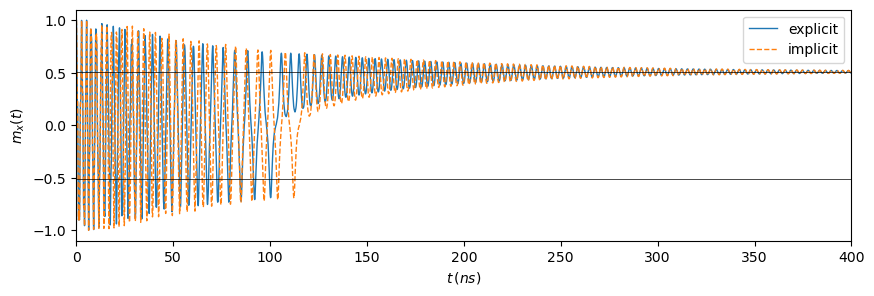

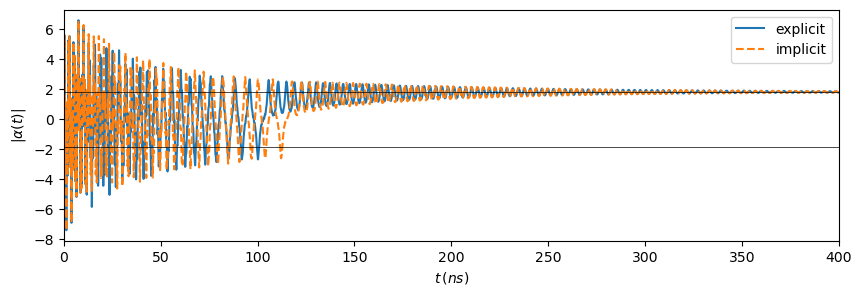

1000000


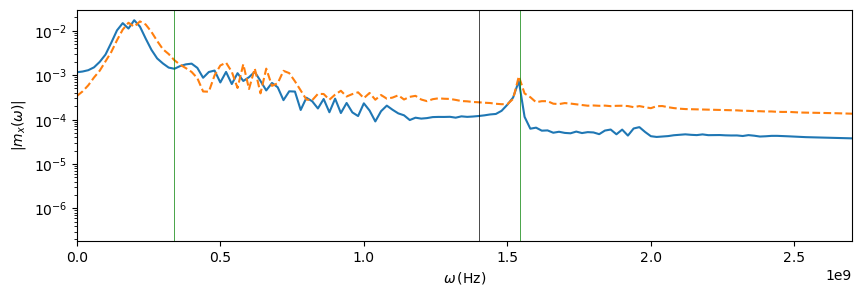

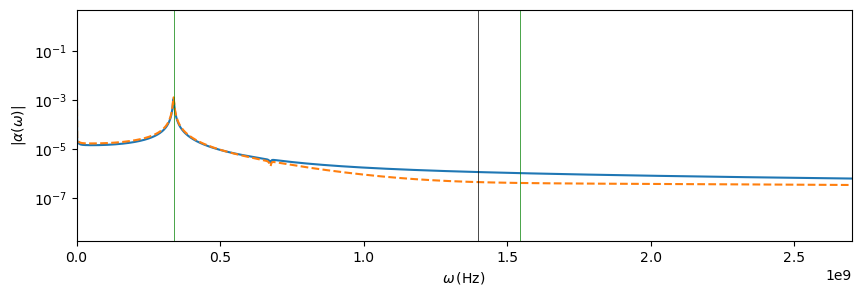

In [23]:
plt.rcParams["figure.figsize"] = (10, 3)

N = 100
tmax = 1000e-9  # 1000
alpha = 1e-3
my0 = 0.01
# m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
m0 = np.array([np.sqrt(1 - my0**2), my0, 0, 0, 0])
alpha0 = 0.5 * (m0[3] - 1j * m0[4])  # fijo alpha0 a partir de x0 y p0
gammaLL = 28e9 * 2 * np.pi
wc = 1.4e9
wz = 0.45 * wc
kappa = 5e-3 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
nu = 0.7
c = 5.124350564859e-19
rho = 5.1e26  # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
wzc = 4 * lam**2 / wc  # freq espines critica, calculo indicativo
print(lam / wc)
print(wzc / wc)

dt = 0.001e-9
t_eval = np.linspace(0, tmax, int(tmax // dt) + 1)  # 100000
print(int(tmax // dt))
# dt = 0.01e-9
# dt = 0.01e-9
sol_exp = solve_ivp(
    eom.LLG_explicit,
    (0, tmax),
    m0,
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
    max_step=dt
)  # , atol = 1, rtol = 1

# dt = 0.01e-9
eom.LLG_memory.S = 0
eom.LLG_memory.C = 0
eom.LLG_memory.last_t = 0.0
sol_imp = solve_ivp(
    eom.LLG_memory,
    (0, tmax),
    m0[:-2],
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha, m0[-2:]),
    t_eval=t_eval,
    max_step=dt,
)


plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if wz / wzc < 1:
    plt.axhline(np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(0, 400)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()


ms_imp = np.array(
    [sol_imp.y[:3, i] for i in range(len(sol_imp.y[0]))]
)  # ajusto el formato del vector de magnetizaciones
alphas_imp = eom.f_alpha(
    ms_imp, sol_imp.t, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha0
)  # genero el vector de alphas
alphas_exp = 0.5 * (sol_exp.y[3] - 1j * sol_exp.y[4])

plt.plot(sol_exp.t * 1e9, np.real(alphas_exp), label="explicit")
plt.plot(sol_imp.t * 1e9, np.real(alphas_imp), ls="dashed", label="implicit")
if wz / wzc < 1:
    plt.axhline(
        np.sqrt(N) * lam / wc * np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5
    )  # stationary alpha
    plt.axhline(
        -np.sqrt(N) * lam / wc * np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5
    )  # stationary alpha

plt.xlim(0, 400)
plt.ylabel(r"$|\alpha(t)|$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()
print(len(sol_exp.t))
w = hamming(len(sol_exp.t))
ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, sol_exp.y[0],
    slice_=slice(5 * len(sol_exp.t) // 100, 10 * len(sol_exp.t) // 100)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, sol_imp.y[0],
    slice_=slice(5 * len(sol_exp.t) // 100, 10 * len(sol_exp.t) // 100)
)  # slice_=slice(len(sol_exp.t)//2, -1)
pm, pp = polaritons.dicke(wz, wc, lam)

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 2.7e9)
plt.ylabel("$|m_x(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, alphas_exp, slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, alphas_imp, slice_=slice(len(sol_exp.t) // 2, -1)
)  # calculo transformada fourier alphas

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 2.7e9)
plt.ylabel(r"$|\alpha(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

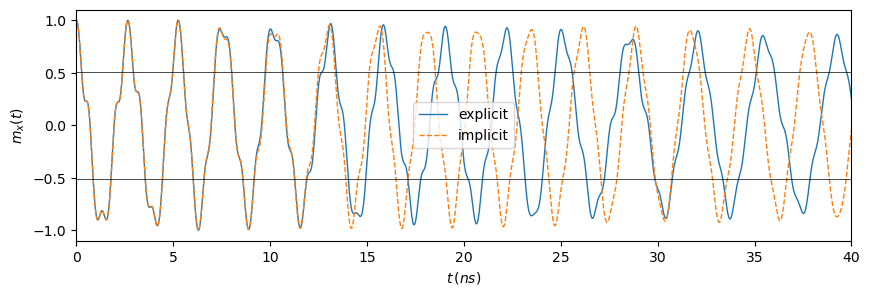

In [24]:
plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if wz / wzc < 1:
    plt.axhline(np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(0, 40)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

100000


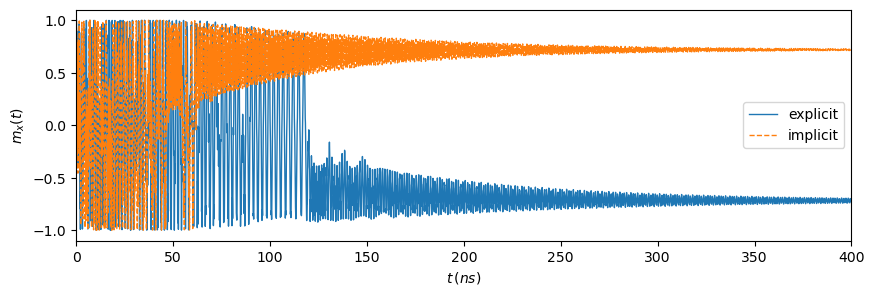

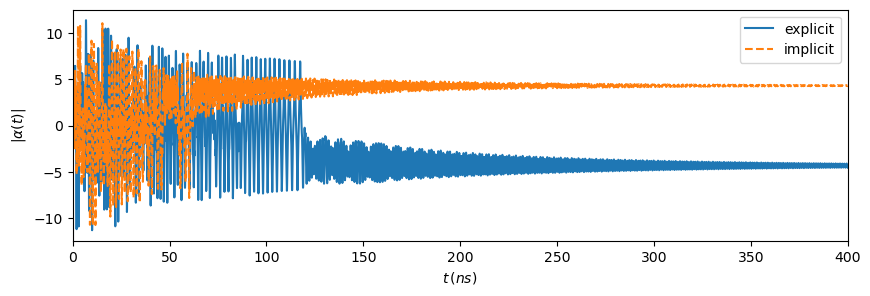

100001


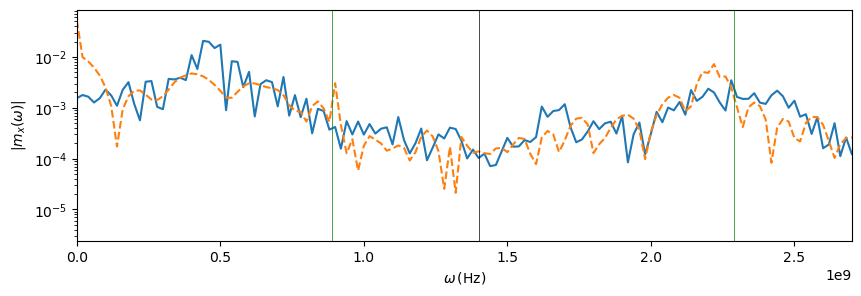

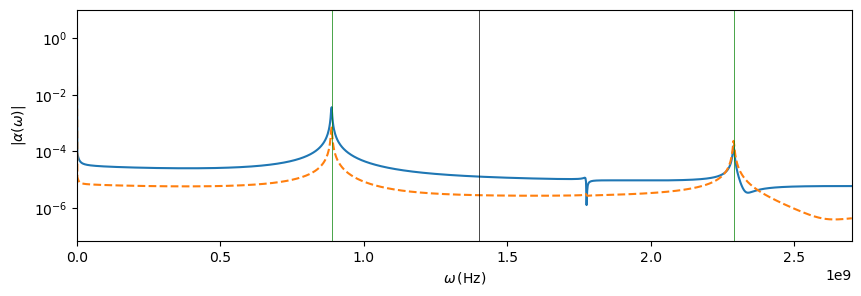

In [29]:
plt.rcParams["figure.figsize"] = (10, 3)

N = 100
tmax = 1000e-9  # 1000
alpha = 1e-3
my0 = 0.01
# m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
m0 = np.array([np.sqrt(1 - my0**2), my0, 0, 0, 0])
alpha0 = 0.5 * (m0[3] - 1j * m0[4])  # fijo alpha0 a partir de x0 y p0
gammaLL = 28e9 * 2 * np.pi
wc = 1.4e9
wz = 1 * wc
kappa = 1e-3 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
lam = 0.6 * wc
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])

dt = 0.01e-9
t_eval = np.linspace(0, tmax, int(tmax // dt) + 1)  # 100000
print(int(tmax // dt))
# dt = 0.01e-9
# dt = 0.01e-9
sol_exp = solve_ivp(
    eom.LLG_explicit,
    (0, tmax),
    m0,
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
    max_step=dt
)  # , atol = 1, rtol = 1

# dt = 0.01e-9
eom.LLG_memory.S = 0
eom.LLG_memory.C = 0
eom.LLG_memory.last_t = 0.0
sol_imp = solve_ivp(
    eom.LLG_memory,
    (0, tmax),
    m0[:-2],
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha, m0[-2:]),
    t_eval=t_eval,
    max_step=dt,
)


plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if wz / wzc < 1:
    plt.axhline(np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(0, 400)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()


ms_imp = np.array(
    [sol_imp.y[:3, i] for i in range(len(sol_imp.y[0]))]
)  # ajusto el formato del vector de magnetizaciones
alphas_imp = eom.f_alpha(
    ms_imp, sol_imp.t, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha0
)  # genero el vector de alphas
alphas_exp = 0.5 * (sol_exp.y[3] - 1j * sol_exp.y[4])

plt.plot(sol_exp.t * 1e9, np.real(alphas_exp), label="explicit")
plt.plot(sol_imp.t * 1e9, np.real(alphas_imp), ls="dashed", label="implicit")
if wz / wzc < 1:
    plt.axhline(
        np.sqrt(N) * lam / wc * np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5
    )  # stationary alpha
    plt.axhline(
        -np.sqrt(N) * lam / wc * np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5
    )  # stationary alpha

plt.xlim(0, 400)
plt.ylabel(r"$|\alpha(t)|$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()
print(len(sol_exp.t))
w = hamming(len(sol_exp.t))
ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, sol_exp.y[0],
    slice_=slice(5 * len(sol_exp.t) // 100, 10 * len(sol_exp.t) // 100)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, sol_imp.y[0],
    slice_=slice(5 * len(sol_exp.t) // 100, 10 * len(sol_exp.t) // 100)
)  # slice_=slice(len(sol_exp.t)//2, -1)
pm, pp = polaritons.dicke(wz, wc, lam)

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 2.7e9)
plt.ylabel("$|m_x(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, alphas_exp, slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, alphas_imp, slice_=slice(len(sol_exp.t) // 2, -1)
)  # calculo transformada fourier alphas

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 2.7e9)
plt.ylabel(r"$|\alpha(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

99999.0


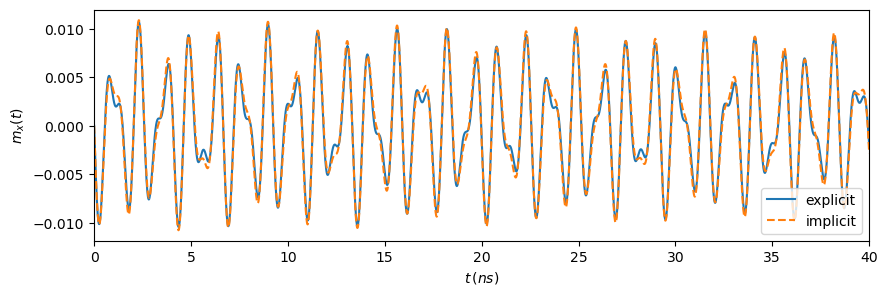

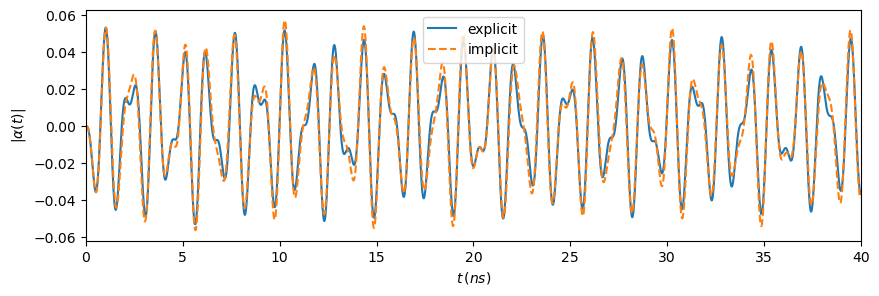

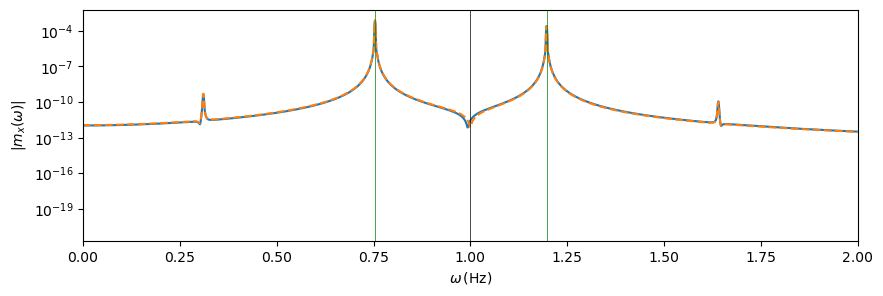

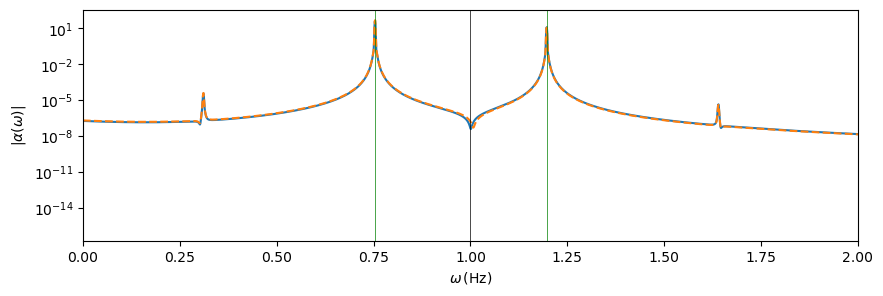

In [127]:
plt.rcParams["figure.figsize"] = (10, 3)

N = 100
tmax = 1000  # 1000
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
alpha0 = 0.5 * (m0[3] - 1j * m0[4])  # fijo alpha0 a partir de x0 y p0
gammaLL = 1
wc = 1
wz = 1 * wc
kappa = 1e-4 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
nu = 0.25
c = 5.124350564859e-19
rho = 5.1e26  # densidad espines FIJA
lam = 0.216
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
wzc = 4 * lam**2 / wc  # freq espines critica, calculo indicativo

dt = 0.01
t_eval = np.linspace(0, tmax, int(tmax // dt))  # 100000
# dt = 0.01e-9
# dt = 0.01e-9
sol_exp = solve_ivp(
    eom.LLG_explicit,
    (0, tmax),
    m0,
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
    max_step=dt,
)  # , atol = 1, rtol = 1

# dt = 0.01
print(tmax // dt)
eom.LLG_memory.S = 0
eom.LLG_memory.C = 0
eom.LLG_memory.last_t = 0.0
sol_imp = solve_ivp(
    eom.LLG_memory,
    (0, tmax),
    m0[:-2],
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha, m0[-2:]),
    t_eval=t_eval,
    max_step=dt,
    atol=1,
    rtol=1,
)


plt.plot(sol_exp.t, sol_exp.y[0], label="explicit")
plt.plot(sol_imp.t, sol_imp.y[0], ls="dashed", label="implicit")
if wz / wzc < 1:
    plt.axhline(np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(0, 40)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()


ms_imp = np.array(
    [sol_imp.y[:3, i] for i in range(len(sol_imp.y[0]))]
)  # ajusto el formato del vector de magnetizaciones
alphas_imp = eom.f_alpha(
    ms_imp, sol_imp.t, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha0
)  # genero el vector de alphas
alphas_exp = 0.5 * (sol_exp.y[3] - 1j * sol_exp.y[4])

plt.plot(sol_exp.t, np.real(alphas_exp), label="explicit")
plt.plot(sol_imp.t, np.real(alphas_imp), ls="dashed", label="implicit")
if wz / wzc < 1:
    plt.axhline(
        np.sqrt(N) * lam / wc * np.sqrt(1 - (wz / wzc) ** 2), c="k", lw=0.5
    )  # stationary alpha

plt.xlim(0, 40)
plt.ylabel(r"$|\alpha(t)|$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

w = blackman(len(sol_exp.t))
ws_exp, amps_exp = fft.fft_wrapper(sol_exp.t, sol_exp.y[0] * w)
ws_imp, amps_imp = fft.fft_wrapper(sol_imp.t, sol_imp.y[0] * w)
pm, pp = polaritons.dicke(wz, wc, lam)

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0, 2)
plt.ylabel("$|m_x(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(sol_exp.t, alphas_exp * w)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, alphas_imp * w
)  # calculo transformada fourier alphas

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0, 2)
plt.ylabel(r"$|\alpha(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

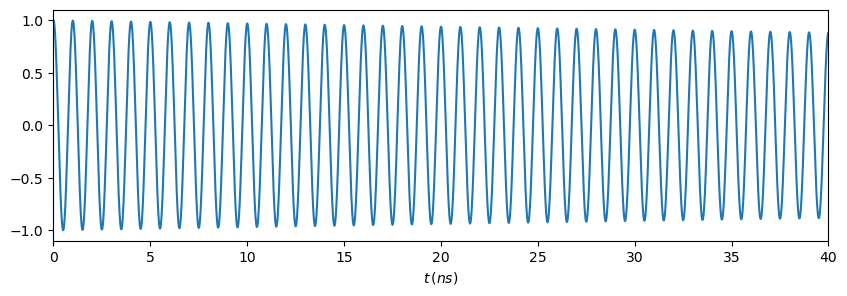

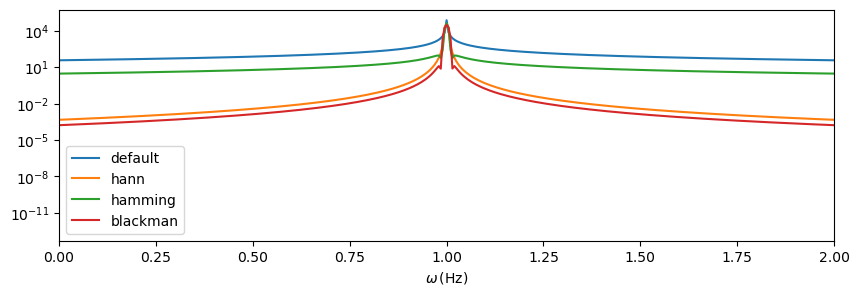

In [108]:
wosc = 1 * (1 + 5e-4j)

ts = np.linspace(0, 200, 100000)

xs = np.exp(1j * 2 * np.pi * wosc * ts)

plt.plot(ts, xs.real)
plt.xlim(0, 40)
plt.xlabel(r"$t \, (ns)$")
plt.show()

ws, amps = fft.fft_wrapper(ts, xs)
plt.plot(ws, np.abs(amps), label="default")

w = hann(len(ts))
ws, amps = fft.fft_wrapper(ts, xs * w)
plt.plot(ws, np.abs(amps), label="hann")

w = hamming(len(ts))
ws, amps = fft.fft_wrapper(ts, xs * w)
plt.plot(ws, np.abs(amps), label="hamming")

w = blackman(len(ts))
ws, amps = fft.fft_wrapper(ts, xs * w)
plt.plot(ws, np.abs(amps), label="blackman")


plt.xlim(0, 2)
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.legend()
plt.show()